# The Street View House Numbers (SVHN) Dataset

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. The dataset and more information can be founded [`here`](http://ufldl.stanford.edu/housenumbers/).

## Loading libraries

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from __future__ import print_function
from urllib import urlretrieve
from scipy.io import loadmat
from skimage.transform import resize
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

## Setting up helper functions

In [3]:
def equalization(labels, size=1000):
    """
    Selects random data with equal size for each label in the dataset.
    
    Args:
    ====
    labels: array of the feature's labels.
    size: int, size of the adjusted dataset.
    
    Return:
    =======
    list of shuffled indexes numbers.
    """
    idx = None
    for i in np.unique(labels):
        draw_bucket, _ = np.where(labels == i)
        samples = np.random.choice(draw_bucket, size=int(size / len(np.unique(labels))))
        if idx is None:
            idx = samples
        else:
            idx = np.concatenate((idx, samples))
    np.random.shuffle(idx)
    return list(idx)

In [4]:
def display_sample_images(features, labels, n, test_data=None, normalized=False):
    """
    Displays a set of images from the dataset.
    
    Args:
    ====
    features: array of images.
    labels: array of the feature's labels.
    n: int, number of images to display.
    normalized: boolean, if True adjusts the function to work with the transformed data.
    """

    fig = plt.figure(figsize=(16, 16))
    for i in range(n):
        plt.subplot(1,n,i + 1)
        image_num = np.random.randint(0, high=len(labels))
        if test_data is not None:
            image_num = test_data
        if normalized:
            image_num = np.random.randint(0, high=10)
            sample_image = np.squeeze(features[image_num], axis=2)
        else:
            sample_image = features[:,:,:,image_num]
        sample_label = labels[image_num]
        
        plt.axis('off')
        plt.title('Label: {}\nFormat: {}\nMin: {:.2f} | Max: {:.2f}'.format(
            sample_label,
            sample_image.shape,
            sample_image.min(),
            sample_image.max()))

        plt.imshow(sample_image)
    plt.show()

In [5]:
def resize_images(features, new_size=(224,224)):
    """
    Resizes the images in the dataset.
    
    Args:
    ====
    features: array of RGB images.
    new_size: int, size of the resizes images.
    
    Return:
    =======
    array of resized images.
    """
    n = features.shape[3]
    resized_images = []
    for i in range(n):
        image = features[:,:,:,i]
        image = resize(image, new_size)
        resized_images.append(image)
    return resized_images

In [6]:
def one_hot_encode(labels):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    
    Args:
    ====
    labels: array of the feature's labels.
    
    Return:
    =======
    array of one-hot encoded labels
    """
    result = []
    for i in range(len(labels)):
        result.append([1 if labels[i] == j + 1 else 0 for j in range(10)])
    return np.array(result)

In [7]:
def batch_creator(features, labels, batch_size, flatted=False):
    """
    Creates batches to feed the model.
    
    Args:
    ====
    features: array of features to use as inputs.
    labels: array of the feature's labels.
    
    Return:
    =======
    generator of batches.
    """
    if flatted:
        for start in range(0, len(features), batch_size):
            end = min(start + batch_size, len(features))
            yield features[start:end,:], labels[start:end]
    else:
        for start in range(0, features.shape[3], batch_size):
            end = min(start + batch_size, features.shape[3])
            yield features[:,:,:,start:end], labels[start:end]

## Loading and understanding the raw data

To create a model that can recognize the digit in the images, it is necessary to understand how this dataset is presented and which transformation will be needed, if any.

In [8]:
if not os.path.isfile('../data/train_32x32.mat'):
    if not os.path.isdir('../data'):
        os.mkdir('../data')
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Dataset') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            '../data/train_32x32.mat',
            pbar.hook)

svhn_data = loadmat('../data/train_32x32.mat')
print('Data loaded!')

SVHN Dataset: 182MB [00:10, 17.9MB/s]                              


Data loaded!


In [9]:
print('Data info: ', svhn_data.keys())
print('Features shape: ', svhn_data['X'].shape)
print('Labels shape: ', svhn_data['y'].shape)

Data info:  ['y', 'X', '__version__', '__header__', '__globals__']
Features shape:  (32, 32, 3, 73257)
Labels shape:  (73257, 1)


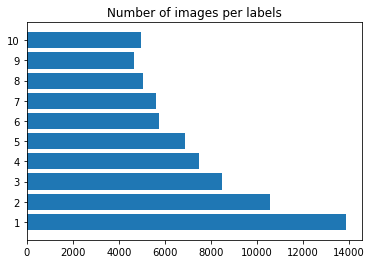

In [17]:
features = svhn_data['X']
labels = svhn_data['y']
count_labels = dict(zip(*np.unique(labels, return_counts=True)))
plt.barh(np.arange(10), count_labels.values())
plt.yticks(np.arange(10), count_labels.keys())
plt.title('Number of images per labels')
plt.show()

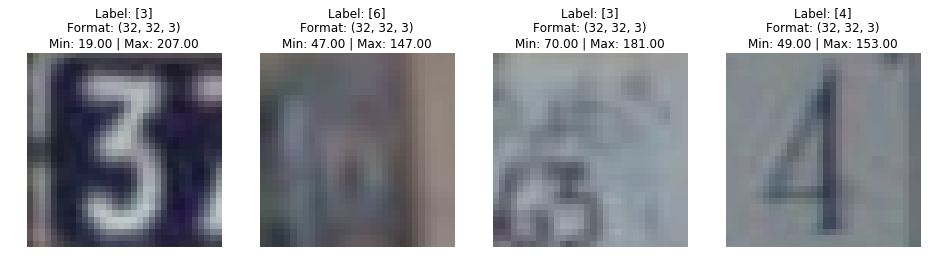

In [18]:
display_sample_images(features, labels, 4)

As it can be seen above, the data has 73000+ RGB images of 32 by 32 pixels, but it has much more examples of 1, 2, 3 and 4. Also the 0 digit is represented as 10.

## Reducing and equalizing data

Since the dataset has not similar examples of the different labels, I'm going to randomly sort the images from the dataset keeping the same size for each label. I also going to reduce the data that will be used to 10000 images to train the model faster.

In [19]:
eq_idx = equalization(labels, 10000)

In [20]:
red_features = features[:,:,:,eq_idx]
red_labels = labels[eq_idx]

print('Features: ', red_features.shape)
print('Labels: ', red_labels.shape)
print('Label Counts: {}'.format(dict(zip(*np.unique(red_labels, return_counts=True)))))

Features:  (32, 32, 3, 10000)
Labels:  (10000, 1)
Label Counts: {1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000, 10: 1000}


## Preprocessing features with pre trained VGG16

To recognize the digit in the images I'll use the VGG16 architecture, but since that model takes a long time to train I'll use a pre trained model and use the first fully connected layer result to train the last two layers.

In [21]:
try:
    from tensorflow_vvg import vgg16
except:
    !git clone https://github.com/machrisaa/tensorflow-vgg.git tensorflow_vgg
    from tensorflow_vgg import vgg16

with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
    urlretrieve(
        'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
        './tensorflow_vgg/vgg16.npy',
        pbar.hook)

Cloning into 'tensorflow_vgg'...
remote: Counting objects: 109, done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (109/109), 56.61 KiB | 0 bytes/s, done.
Resolving deltas: 100% (58/58), done.
Checking connectivity... done.


VGG16 Parameters: 553MB [00:08, 62.5MB/s]                              


In [22]:
if not os.path.isfile('./code_data.pkl'):
    batch_size = 10
    iteration = 0
    codes = None
    with tf.Session() as sess:
        vgg = vgg16.Vgg16()
        images = tf.placeholder(tf.float32, [None, 224, 224, 3])
        with tf.name_scope('content_vgg'):
            vgg.build(images)
    
        for batch, _ in batch_creator(red_features, red_labels, batch_size):
            print('Processing batch #{:3d}'.format(iteration))
            resized_images = resize_images(batch)
            feed_dict = {images: resized_images}
            codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
            if codes is None:
                codes = codes_batch
            else:
                codes = np.concatenate((codes, codes_batch))
            iteration += 1
        
    with open('./code_data.pkl', 'wb') as f:
        pickle.dump(codes, f)
else:
    with open('./code_data.pkl', 'rb') as f:
        codes = pickle.load(f)

/home/carnd/machine-learning/mlnd_capstone/project/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Processing batch #  0


/home/carnd/anaconda3/envs/mlcap/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Processing batch #  1
Processing batch #  2
Processing batch #  3
Processing batch #  4
Processing batch #  5
Processing batch #  6
Processing batch #  7
Processing batch #  8
Processing batch #  9
Processing batch # 10
Processing batch # 11
Processing batch # 12
Processing batch # 13
Processing batch # 14
Processing batch # 15
Processing batch # 16
Processing batch # 17
Processing batch # 18
Processing batch # 19
Processing batch # 20
Processing batch # 21
Processing batch # 22
Processing batch # 23
Processing batch # 24
Processing batch # 25
Processing batch # 26
Processing batch # 27
Processing batch # 28
Processing batch # 29
Processing batch # 30
Processing batch # 31
Processing batch # 32
Processing batch # 33
Processing batch # 34
Processing batch # 35
Processing batch # 36
Processing batch # 37
Processing batch # 38
Processing batch # 39
Processing batch # 40
Processing batch # 41
Processing batch # 42
Processing batch # 43
Processing batch # 44
Processing batch # 45
Processing

Processing batch #374
Processing batch #375
Processing batch #376
Processing batch #377
Processing batch #378
Processing batch #379
Processing batch #380
Processing batch #381
Processing batch #382
Processing batch #383
Processing batch #384
Processing batch #385
Processing batch #386
Processing batch #387
Processing batch #388
Processing batch #389
Processing batch #390
Processing batch #391
Processing batch #392
Processing batch #393
Processing batch #394
Processing batch #395
Processing batch #396
Processing batch #397
Processing batch #398
Processing batch #399
Processing batch #400
Processing batch #401
Processing batch #402
Processing batch #403
Processing batch #404
Processing batch #405
Processing batch #406
Processing batch #407
Processing batch #408
Processing batch #409
Processing batch #410
Processing batch #411
Processing batch #412
Processing batch #413
Processing batch #414
Processing batch #415
Processing batch #416
Processing batch #417
Processing batch #418
Processing

Processing batch #747
Processing batch #748
Processing batch #749
Processing batch #750
Processing batch #751
Processing batch #752
Processing batch #753
Processing batch #754
Processing batch #755
Processing batch #756
Processing batch #757
Processing batch #758
Processing batch #759
Processing batch #760
Processing batch #761
Processing batch #762
Processing batch #763
Processing batch #764
Processing batch #765
Processing batch #766
Processing batch #767
Processing batch #768
Processing batch #769
Processing batch #770
Processing batch #771
Processing batch #772
Processing batch #773
Processing batch #774
Processing batch #775
Processing batch #776
Processing batch #777
Processing batch #778
Processing batch #779
Processing batch #780
Processing batch #781
Processing batch #782
Processing batch #783
Processing batch #784
Processing batch #785
Processing batch #786
Processing batch #787
Processing batch #788
Processing batch #789
Processing batch #790
Processing batch #791
Processing

In [23]:
print(codes.shape)

(10000, 4096)


## One hot enconding the labels

Also we need to one hot encode the labels

In [24]:
one_hot_labels = one_hot_encode(red_labels)
print(one_hot_labels.shape)

(10000, 10)


## Splitting the data for final training

Here I'll split the data in train, validation and test.

In [25]:
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

train_idx, val_idx = next(ss.split(codes, one_hot_labels))

half_val_len = int(len(val_idx) / 2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = codes[train_idx], one_hot_labels[train_idx]
val_x, val_y = codes[val_idx], one_hot_labels[val_idx]
test_x, test_y = codes[test_idx], one_hot_labels[test_idx]

In [26]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (8000, 4096) (8000, 10)
Validation shapes (x, y): (1000, 4096) (1000, 10)
Test shapes (x, y): (1000, 4096) (1000, 10)


## Building the fully connected layers

I'll build the last two layers of the model and use the result of the pre trained VGG16 as inputs.

In [27]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, one_hot_labels.shape[1]])
keep_prob = tf.placeholder(tf.float32)

relu7 = tf.layers.dense(inputs_, codes.shape[1], activation=tf.nn.relu)
drop7 = tf.nn.dropout(relu7, keep_prob)

logits = tf.layers.dense(drop7, one_hot_labels.shape[1])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Training

In [34]:
epochs = 100
batch_size = 100
iteration = 0

if not os.path.isdir('./checkpoints'):
    !mkdir ./checkpoints

saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in batch_creator(train_x, train_y, batch_size=batch_size, flatted=True):
            feed = {inputs_: x,
                    labels_: y,
                    keep_prob: 0.5
                   }
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e, epochs - 1),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            
            if iteration % 50 == 0 or iteration == ((train_x.shape[0] * epochs / batch_size) - 1):
                feed = {inputs_: val_x,
                        labels_: val_y,
                        keep_prob: 1.0
                       }
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("***\nEpoch: {}/{}".format(e, epochs - 1),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}\n***".format(val_acc))
            
            iteration += 1
            
    saver.save(sess, "./checkpoints/svhn.ckpt")

Epoch: 0/99 Iteration: 0 Training loss: 4.35376
***
Epoch: 0/99 Iteration: 0 Validation Acc: 0.1110
***
Epoch: 0/99 Iteration: 1 Training loss: 44.39518
Epoch: 0/99 Iteration: 2 Training loss: 49.34168
Epoch: 0/99 Iteration: 3 Training loss: 52.91121
Epoch: 0/99 Iteration: 4 Training loss: 49.66009
Epoch: 0/99 Iteration: 5 Training loss: 45.84847
Epoch: 0/99 Iteration: 6 Training loss: 44.63792
Epoch: 0/99 Iteration: 7 Training loss: 37.06716
Epoch: 0/99 Iteration: 8 Training loss: 36.01100
Epoch: 0/99 Iteration: 9 Training loss: 32.04633
Epoch: 0/99 Iteration: 10 Training loss: 25.31068
Epoch: 0/99 Iteration: 11 Training loss: 14.30380
Epoch: 0/99 Iteration: 12 Training loss: 10.27031
Epoch: 0/99 Iteration: 13 Training loss: 12.33575
Epoch: 0/99 Iteration: 14 Training loss: 11.13775
Epoch: 0/99 Iteration: 15 Training loss: 10.70842
Epoch: 0/99 Iteration: 16 Training loss: 8.49321
Epoch: 0/99 Iteration: 17 Training loss: 8.81977
Epoch: 0/99 Iteration: 18 Training loss: 7.78865
Epoch: 0

Epoch: 2/99 Iteration: 163 Training loss: 1.00181
Epoch: 2/99 Iteration: 164 Training loss: 0.94810
Epoch: 2/99 Iteration: 165 Training loss: 1.01120
Epoch: 2/99 Iteration: 166 Training loss: 0.93516
Epoch: 2/99 Iteration: 167 Training loss: 0.96779
Epoch: 2/99 Iteration: 168 Training loss: 1.11334
Epoch: 2/99 Iteration: 169 Training loss: 0.93222
Epoch: 2/99 Iteration: 170 Training loss: 0.93731
Epoch: 2/99 Iteration: 171 Training loss: 1.01708
Epoch: 2/99 Iteration: 172 Training loss: 1.03271
Epoch: 2/99 Iteration: 173 Training loss: 0.95002
Epoch: 2/99 Iteration: 174 Training loss: 1.21745
Epoch: 2/99 Iteration: 175 Training loss: 0.94850
Epoch: 2/99 Iteration: 176 Training loss: 0.75957
Epoch: 2/99 Iteration: 177 Training loss: 0.87228
Epoch: 2/99 Iteration: 178 Training loss: 0.98388
Epoch: 2/99 Iteration: 179 Training loss: 0.96772
Epoch: 2/99 Iteration: 180 Training loss: 0.87587
Epoch: 2/99 Iteration: 181 Training loss: 0.91102
Epoch: 2/99 Iteration: 182 Training loss: 1.05622


Epoch: 4/99 Iteration: 328 Training loss: 0.87261
Epoch: 4/99 Iteration: 329 Training loss: 0.76227
Epoch: 4/99 Iteration: 330 Training loss: 0.68636
Epoch: 4/99 Iteration: 331 Training loss: 0.74201
Epoch: 4/99 Iteration: 332 Training loss: 0.78353
Epoch: 4/99 Iteration: 333 Training loss: 0.77672
Epoch: 4/99 Iteration: 334 Training loss: 0.98424
Epoch: 4/99 Iteration: 335 Training loss: 0.76339
Epoch: 4/99 Iteration: 336 Training loss: 0.56169
Epoch: 4/99 Iteration: 337 Training loss: 0.61945
Epoch: 4/99 Iteration: 338 Training loss: 0.91484
Epoch: 4/99 Iteration: 339 Training loss: 0.72232
Epoch: 4/99 Iteration: 340 Training loss: 0.68283
Epoch: 4/99 Iteration: 341 Training loss: 0.76282
Epoch: 4/99 Iteration: 342 Training loss: 0.77532
Epoch: 4/99 Iteration: 343 Training loss: 0.82613
Epoch: 4/99 Iteration: 344 Training loss: 0.72356
Epoch: 4/99 Iteration: 345 Training loss: 0.83887
Epoch: 4/99 Iteration: 346 Training loss: 0.71537
Epoch: 4/99 Iteration: 347 Training loss: 0.60792


Epoch: 6/99 Iteration: 493 Training loss: 0.70774
Epoch: 6/99 Iteration: 494 Training loss: 0.82646
Epoch: 6/99 Iteration: 495 Training loss: 0.57855
Epoch: 6/99 Iteration: 496 Training loss: 0.58452
Epoch: 6/99 Iteration: 497 Training loss: 0.59290
Epoch: 6/99 Iteration: 498 Training loss: 0.73772
Epoch: 6/99 Iteration: 499 Training loss: 0.66159
Epoch: 6/99 Iteration: 500 Training loss: 0.66866
***
Epoch: 6/99 Iteration: 500 Validation Acc: 0.7610
***
Epoch: 6/99 Iteration: 501 Training loss: 0.63403
Epoch: 6/99 Iteration: 502 Training loss: 0.67258
Epoch: 6/99 Iteration: 503 Training loss: 0.69707
Epoch: 6/99 Iteration: 504 Training loss: 0.62980
Epoch: 6/99 Iteration: 505 Training loss: 0.62208
Epoch: 6/99 Iteration: 506 Training loss: 0.63786
Epoch: 6/99 Iteration: 507 Training loss: 0.57346
Epoch: 6/99 Iteration: 508 Training loss: 0.75377
Epoch: 6/99 Iteration: 509 Training loss: 0.94896
Epoch: 6/99 Iteration: 510 Training loss: 0.57580
Epoch: 6/99 Iteration: 511 Training loss: 

Epoch: 8/99 Iteration: 657 Training loss: 0.54094
Epoch: 8/99 Iteration: 658 Training loss: 0.63704
Epoch: 8/99 Iteration: 659 Training loss: 0.59740
Epoch: 8/99 Iteration: 660 Training loss: 0.62257
Epoch: 8/99 Iteration: 661 Training loss: 0.51221
Epoch: 8/99 Iteration: 662 Training loss: 0.53026
Epoch: 8/99 Iteration: 663 Training loss: 0.64209
Epoch: 8/99 Iteration: 664 Training loss: 0.52415
Epoch: 8/99 Iteration: 665 Training loss: 0.63555
Epoch: 8/99 Iteration: 666 Training loss: 0.60632
Epoch: 8/99 Iteration: 667 Training loss: 0.49815
Epoch: 8/99 Iteration: 668 Training loss: 0.68738
Epoch: 8/99 Iteration: 669 Training loss: 0.78268
Epoch: 8/99 Iteration: 670 Training loss: 0.46574
Epoch: 8/99 Iteration: 671 Training loss: 0.42322
Epoch: 8/99 Iteration: 672 Training loss: 0.60712
Epoch: 8/99 Iteration: 673 Training loss: 0.66824
Epoch: 8/99 Iteration: 674 Training loss: 0.53857
Epoch: 8/99 Iteration: 675 Training loss: 0.56853
Epoch: 8/99 Iteration: 676 Training loss: 0.88102


Epoch: 10/99 Iteration: 822 Training loss: 0.66868
Epoch: 10/99 Iteration: 823 Training loss: 0.61303
Epoch: 10/99 Iteration: 824 Training loss: 0.46198
Epoch: 10/99 Iteration: 825 Training loss: 0.56877
Epoch: 10/99 Iteration: 826 Training loss: 0.61189
Epoch: 10/99 Iteration: 827 Training loss: 0.51822
Epoch: 10/99 Iteration: 828 Training loss: 0.68249
Epoch: 10/99 Iteration: 829 Training loss: 0.78428
Epoch: 10/99 Iteration: 830 Training loss: 0.50193
Epoch: 10/99 Iteration: 831 Training loss: 0.46784
Epoch: 10/99 Iteration: 832 Training loss: 0.60191
Epoch: 10/99 Iteration: 833 Training loss: 0.62569
Epoch: 10/99 Iteration: 834 Training loss: 0.56264
Epoch: 10/99 Iteration: 835 Training loss: 0.49594
Epoch: 10/99 Iteration: 836 Training loss: 0.71858
Epoch: 10/99 Iteration: 837 Training loss: 0.54529
Epoch: 10/99 Iteration: 838 Training loss: 0.66146
Epoch: 10/99 Iteration: 839 Training loss: 0.60061
Epoch: 10/99 Iteration: 840 Training loss: 0.53982
Epoch: 10/99 Iteration: 841 Tra

Epoch: 12/99 Iteration: 980 Training loss: 0.60285
Epoch: 12/99 Iteration: 981 Training loss: 0.51275
Epoch: 12/99 Iteration: 982 Training loss: 0.58344
Epoch: 12/99 Iteration: 983 Training loss: 0.52368
Epoch: 12/99 Iteration: 984 Training loss: 0.53380
Epoch: 12/99 Iteration: 985 Training loss: 0.56838
Epoch: 12/99 Iteration: 986 Training loss: 0.65917
Epoch: 12/99 Iteration: 987 Training loss: 0.48929
Epoch: 12/99 Iteration: 988 Training loss: 0.62937
Epoch: 12/99 Iteration: 989 Training loss: 0.60670
Epoch: 12/99 Iteration: 990 Training loss: 0.49073
Epoch: 12/99 Iteration: 991 Training loss: 0.55758
Epoch: 12/99 Iteration: 992 Training loss: 0.61940
Epoch: 12/99 Iteration: 993 Training loss: 0.55297
Epoch: 12/99 Iteration: 994 Training loss: 0.47776
Epoch: 12/99 Iteration: 995 Training loss: 0.50915
Epoch: 12/99 Iteration: 996 Training loss: 0.75522
Epoch: 12/99 Iteration: 997 Training loss: 0.48180
Epoch: 12/99 Iteration: 998 Training loss: 0.49024
Epoch: 12/99 Iteration: 999 Tra

Epoch: 14/99 Iteration: 1138 Training loss: 0.49874
Epoch: 14/99 Iteration: 1139 Training loss: 0.45835
Epoch: 14/99 Iteration: 1140 Training loss: 0.61753
Epoch: 14/99 Iteration: 1141 Training loss: 0.44287
Epoch: 14/99 Iteration: 1142 Training loss: 0.56069
Epoch: 14/99 Iteration: 1143 Training loss: 0.60306
Epoch: 14/99 Iteration: 1144 Training loss: 0.47669
Epoch: 14/99 Iteration: 1145 Training loss: 0.45848
Epoch: 14/99 Iteration: 1146 Training loss: 0.52084
Epoch: 14/99 Iteration: 1147 Training loss: 0.38961
Epoch: 14/99 Iteration: 1148 Training loss: 0.52953
Epoch: 14/99 Iteration: 1149 Training loss: 0.76411
Epoch: 14/99 Iteration: 1150 Training loss: 0.43552
***
Epoch: 14/99 Iteration: 1150 Validation Acc: 0.8160
***
Epoch: 14/99 Iteration: 1151 Training loss: 0.31313
Epoch: 14/99 Iteration: 1152 Training loss: 0.50626
Epoch: 14/99 Iteration: 1153 Training loss: 0.70039
Epoch: 14/99 Iteration: 1154 Training loss: 0.48064
Epoch: 14/99 Iteration: 1155 Training loss: 0.53311
Epoc

Epoch: 16/99 Iteration: 1296 Training loss: 0.44282
Epoch: 16/99 Iteration: 1297 Training loss: 0.42464
Epoch: 16/99 Iteration: 1298 Training loss: 0.59031
Epoch: 16/99 Iteration: 1299 Training loss: 0.52783
Epoch: 16/99 Iteration: 1300 Training loss: 0.54240
***
Epoch: 16/99 Iteration: 1300 Validation Acc: 0.7990
***
Epoch: 16/99 Iteration: 1301 Training loss: 0.48531
Epoch: 16/99 Iteration: 1302 Training loss: 0.48221
Epoch: 16/99 Iteration: 1303 Training loss: 0.57746
Epoch: 16/99 Iteration: 1304 Training loss: 0.47550
Epoch: 16/99 Iteration: 1305 Training loss: 0.55596
Epoch: 16/99 Iteration: 1306 Training loss: 0.51853
Epoch: 16/99 Iteration: 1307 Training loss: 0.42860
Epoch: 16/99 Iteration: 1308 Training loss: 0.58889
Epoch: 16/99 Iteration: 1309 Training loss: 0.69740
Epoch: 16/99 Iteration: 1310 Training loss: 0.38362
Epoch: 16/99 Iteration: 1311 Training loss: 0.52178
Epoch: 16/99 Iteration: 1312 Training loss: 0.60752
Epoch: 16/99 Iteration: 1313 Training loss: 0.47334
Epoc

Epoch: 18/99 Iteration: 1453 Training loss: 0.54596
Epoch: 18/99 Iteration: 1454 Training loss: 0.75706
Epoch: 18/99 Iteration: 1455 Training loss: 0.49159
Epoch: 18/99 Iteration: 1456 Training loss: 0.41068
Epoch: 18/99 Iteration: 1457 Training loss: 0.41195
Epoch: 18/99 Iteration: 1458 Training loss: 0.52984
Epoch: 18/99 Iteration: 1459 Training loss: 0.53392
Epoch: 18/99 Iteration: 1460 Training loss: 0.50538
Epoch: 18/99 Iteration: 1461 Training loss: 0.38656
Epoch: 18/99 Iteration: 1462 Training loss: 0.44862
Epoch: 18/99 Iteration: 1463 Training loss: 0.46348
Epoch: 18/99 Iteration: 1464 Training loss: 0.48375
Epoch: 18/99 Iteration: 1465 Training loss: 0.48071
Epoch: 18/99 Iteration: 1466 Training loss: 0.55029
Epoch: 18/99 Iteration: 1467 Training loss: 0.45413
Epoch: 18/99 Iteration: 1468 Training loss: 0.52037
Epoch: 18/99 Iteration: 1469 Training loss: 0.64453
Epoch: 18/99 Iteration: 1470 Training loss: 0.39448
Epoch: 18/99 Iteration: 1471 Training loss: 0.39844
Epoch: 18/99

Epoch: 20/99 Iteration: 1611 Training loss: 0.47864
Epoch: 20/99 Iteration: 1612 Training loss: 0.48170
Epoch: 20/99 Iteration: 1613 Training loss: 0.58366
Epoch: 20/99 Iteration: 1614 Training loss: 0.54639
Epoch: 20/99 Iteration: 1615 Training loss: 0.47710
Epoch: 20/99 Iteration: 1616 Training loss: 0.51743
Epoch: 20/99 Iteration: 1617 Training loss: 0.46420
Epoch: 20/99 Iteration: 1618 Training loss: 0.54484
Epoch: 20/99 Iteration: 1619 Training loss: 0.42814
Epoch: 20/99 Iteration: 1620 Training loss: 0.51199
Epoch: 20/99 Iteration: 1621 Training loss: 0.46205
Epoch: 20/99 Iteration: 1622 Training loss: 0.59882
Epoch: 20/99 Iteration: 1623 Training loss: 0.56463
Epoch: 20/99 Iteration: 1624 Training loss: 0.43899
Epoch: 20/99 Iteration: 1625 Training loss: 0.56951
Epoch: 20/99 Iteration: 1626 Training loss: 0.55147
Epoch: 20/99 Iteration: 1627 Training loss: 0.41653
Epoch: 20/99 Iteration: 1628 Training loss: 0.57943
Epoch: 20/99 Iteration: 1629 Training loss: 0.65693
Epoch: 20/99

Epoch: 22/99 Iteration: 1769 Training loss: 0.40881
Epoch: 22/99 Iteration: 1770 Training loss: 0.49870
Epoch: 22/99 Iteration: 1771 Training loss: 0.42655
Epoch: 22/99 Iteration: 1772 Training loss: 0.50266
Epoch: 22/99 Iteration: 1773 Training loss: 0.53253
Epoch: 22/99 Iteration: 1774 Training loss: 0.54539
Epoch: 22/99 Iteration: 1775 Training loss: 0.47298
Epoch: 22/99 Iteration: 1776 Training loss: 0.43183
Epoch: 22/99 Iteration: 1777 Training loss: 0.39587
Epoch: 22/99 Iteration: 1778 Training loss: 0.47451
Epoch: 22/99 Iteration: 1779 Training loss: 0.43864
Epoch: 22/99 Iteration: 1780 Training loss: 0.53373
Epoch: 22/99 Iteration: 1781 Training loss: 0.48158
Epoch: 22/99 Iteration: 1782 Training loss: 0.48717
Epoch: 22/99 Iteration: 1783 Training loss: 0.52623
Epoch: 22/99 Iteration: 1784 Training loss: 0.42795
Epoch: 22/99 Iteration: 1785 Training loss: 0.48298
Epoch: 22/99 Iteration: 1786 Training loss: 0.40752
Epoch: 22/99 Iteration: 1787 Training loss: 0.33925
Epoch: 22/99

Epoch: 24/99 Iteration: 1927 Training loss: 0.44129
Epoch: 24/99 Iteration: 1928 Training loss: 0.52790
Epoch: 24/99 Iteration: 1929 Training loss: 0.46295
Epoch: 24/99 Iteration: 1930 Training loss: 0.47927
Epoch: 24/99 Iteration: 1931 Training loss: 0.44300
Epoch: 24/99 Iteration: 1932 Training loss: 0.42157
Epoch: 24/99 Iteration: 1933 Training loss: 0.49599
Epoch: 24/99 Iteration: 1934 Training loss: 0.51371
Epoch: 24/99 Iteration: 1935 Training loss: 0.36454
Epoch: 24/99 Iteration: 1936 Training loss: 0.35920
Epoch: 24/99 Iteration: 1937 Training loss: 0.30905
Epoch: 24/99 Iteration: 1938 Training loss: 0.47825
Epoch: 24/99 Iteration: 1939 Training loss: 0.39674
Epoch: 24/99 Iteration: 1940 Training loss: 0.46975
Epoch: 24/99 Iteration: 1941 Training loss: 0.62270
Epoch: 24/99 Iteration: 1942 Training loss: 0.41162
Epoch: 24/99 Iteration: 1943 Training loss: 0.60178
Epoch: 24/99 Iteration: 1944 Training loss: 0.45176
Epoch: 24/99 Iteration: 1945 Training loss: 0.58388
Epoch: 24/99

Epoch: 26/99 Iteration: 2085 Training loss: 0.50082
Epoch: 26/99 Iteration: 2086 Training loss: 0.47062
Epoch: 26/99 Iteration: 2087 Training loss: 0.66382
Epoch: 26/99 Iteration: 2088 Training loss: 0.63386
Epoch: 26/99 Iteration: 2089 Training loss: 0.51912
Epoch: 26/99 Iteration: 2090 Training loss: 0.50894
Epoch: 26/99 Iteration: 2091 Training loss: 0.51314
Epoch: 26/99 Iteration: 2092 Training loss: 0.51277
Epoch: 26/99 Iteration: 2093 Training loss: 0.65604
Epoch: 26/99 Iteration: 2094 Training loss: 0.69534
Epoch: 26/99 Iteration: 2095 Training loss: 0.31514
Epoch: 26/99 Iteration: 2096 Training loss: 0.48839
Epoch: 26/99 Iteration: 2097 Training loss: 0.44707
Epoch: 26/99 Iteration: 2098 Training loss: 0.43594
Epoch: 26/99 Iteration: 2099 Training loss: 0.54125
Epoch: 26/99 Iteration: 2100 Training loss: 0.49921
***
Epoch: 26/99 Iteration: 2100 Validation Acc: 0.8200
***
Epoch: 26/99 Iteration: 2101 Training loss: 0.45583
Epoch: 26/99 Iteration: 2102 Training loss: 0.61560
Epoc

Epoch: 28/99 Iteration: 2243 Training loss: 0.51210
Epoch: 28/99 Iteration: 2244 Training loss: 0.34704
Epoch: 28/99 Iteration: 2245 Training loss: 0.39600
Epoch: 28/99 Iteration: 2246 Training loss: 0.43689
Epoch: 28/99 Iteration: 2247 Training loss: 0.52992
Epoch: 28/99 Iteration: 2248 Training loss: 0.62054
Epoch: 28/99 Iteration: 2249 Training loss: 0.64865
Epoch: 28/99 Iteration: 2250 Training loss: 0.40322
***
Epoch: 28/99 Iteration: 2250 Validation Acc: 0.8100
***
Epoch: 28/99 Iteration: 2251 Training loss: 0.38840
Epoch: 28/99 Iteration: 2252 Training loss: 0.38866
Epoch: 28/99 Iteration: 2253 Training loss: 0.46218
Epoch: 28/99 Iteration: 2254 Training loss: 0.61271
Epoch: 28/99 Iteration: 2255 Training loss: 0.54544
Epoch: 28/99 Iteration: 2256 Training loss: 0.42501
Epoch: 28/99 Iteration: 2257 Training loss: 0.41123
Epoch: 28/99 Iteration: 2258 Training loss: 0.48744
Epoch: 28/99 Iteration: 2259 Training loss: 0.38712
Epoch: 28/99 Iteration: 2260 Training loss: 0.37300
Epoc

***
Epoch: 30/99 Iteration: 2400 Validation Acc: 0.8320
***
Epoch: 30/99 Iteration: 2401 Training loss: 0.41615
Epoch: 30/99 Iteration: 2402 Training loss: 0.54470
Epoch: 30/99 Iteration: 2403 Training loss: 0.41892
Epoch: 30/99 Iteration: 2404 Training loss: 0.39579
Epoch: 30/99 Iteration: 2405 Training loss: 0.40876
Epoch: 30/99 Iteration: 2406 Training loss: 0.46753
Epoch: 30/99 Iteration: 2407 Training loss: 0.35126
Epoch: 30/99 Iteration: 2408 Training loss: 0.57807
Epoch: 30/99 Iteration: 2409 Training loss: 0.46953
Epoch: 30/99 Iteration: 2410 Training loss: 0.36997
Epoch: 30/99 Iteration: 2411 Training loss: 0.38581
Epoch: 30/99 Iteration: 2412 Training loss: 0.36455
Epoch: 30/99 Iteration: 2413 Training loss: 0.51292
Epoch: 30/99 Iteration: 2414 Training loss: 0.61790
Epoch: 30/99 Iteration: 2415 Training loss: 0.46538
Epoch: 30/99 Iteration: 2416 Training loss: 0.36508
Epoch: 30/99 Iteration: 2417 Training loss: 0.28755
Epoch: 30/99 Iteration: 2418 Training loss: 0.55035
Epoc

Epoch: 31/99 Iteration: 2558 Training loss: 0.34399
Epoch: 31/99 Iteration: 2559 Training loss: 0.45806
Epoch: 32/99 Iteration: 2560 Training loss: 0.28452
Epoch: 32/99 Iteration: 2561 Training loss: 0.60455
Epoch: 32/99 Iteration: 2562 Training loss: 0.36643
Epoch: 32/99 Iteration: 2563 Training loss: 0.58360
Epoch: 32/99 Iteration: 2564 Training loss: 0.42949
Epoch: 32/99 Iteration: 2565 Training loss: 0.35447
Epoch: 32/99 Iteration: 2566 Training loss: 0.44659
Epoch: 32/99 Iteration: 2567 Training loss: 0.33066
Epoch: 32/99 Iteration: 2568 Training loss: 0.58117
Epoch: 32/99 Iteration: 2569 Training loss: 0.31007
Epoch: 32/99 Iteration: 2570 Training loss: 0.36773
Epoch: 32/99 Iteration: 2571 Training loss: 0.42018
Epoch: 32/99 Iteration: 2572 Training loss: 0.42804
Epoch: 32/99 Iteration: 2573 Training loss: 0.46785
Epoch: 32/99 Iteration: 2574 Training loss: 0.47353
Epoch: 32/99 Iteration: 2575 Training loss: 0.35419
Epoch: 32/99 Iteration: 2576 Training loss: 0.45191
Epoch: 32/99

Epoch: 33/99 Iteration: 2716 Training loss: 0.41401
Epoch: 33/99 Iteration: 2717 Training loss: 0.54734
Epoch: 33/99 Iteration: 2718 Training loss: 0.48635
Epoch: 33/99 Iteration: 2719 Training loss: 0.52584
Epoch: 34/99 Iteration: 2720 Training loss: 0.34428
Epoch: 34/99 Iteration: 2721 Training loss: 0.48808
Epoch: 34/99 Iteration: 2722 Training loss: 0.59069
Epoch: 34/99 Iteration: 2723 Training loss: 0.48004
Epoch: 34/99 Iteration: 2724 Training loss: 0.42680
Epoch: 34/99 Iteration: 2725 Training loss: 0.41263
Epoch: 34/99 Iteration: 2726 Training loss: 0.43023
Epoch: 34/99 Iteration: 2727 Training loss: 0.41234
Epoch: 34/99 Iteration: 2728 Training loss: 0.61973
Epoch: 34/99 Iteration: 2729 Training loss: 0.41141
Epoch: 34/99 Iteration: 2730 Training loss: 0.31734
Epoch: 34/99 Iteration: 2731 Training loss: 0.39474
Epoch: 34/99 Iteration: 2732 Training loss: 0.34180
Epoch: 34/99 Iteration: 2733 Training loss: 0.47184
Epoch: 34/99 Iteration: 2734 Training loss: 0.52185
Epoch: 34/99

Epoch: 35/99 Iteration: 2874 Training loss: 0.40975
Epoch: 35/99 Iteration: 2875 Training loss: 0.48766
Epoch: 35/99 Iteration: 2876 Training loss: 0.41270
Epoch: 35/99 Iteration: 2877 Training loss: 0.33027
Epoch: 35/99 Iteration: 2878 Training loss: 0.34413
Epoch: 35/99 Iteration: 2879 Training loss: 0.49267
Epoch: 36/99 Iteration: 2880 Training loss: 0.45697
Epoch: 36/99 Iteration: 2881 Training loss: 0.45347
Epoch: 36/99 Iteration: 2882 Training loss: 0.48523
Epoch: 36/99 Iteration: 2883 Training loss: 0.56578
Epoch: 36/99 Iteration: 2884 Training loss: 0.48530
Epoch: 36/99 Iteration: 2885 Training loss: 0.46178
Epoch: 36/99 Iteration: 2886 Training loss: 0.46946
Epoch: 36/99 Iteration: 2887 Training loss: 0.43938
Epoch: 36/99 Iteration: 2888 Training loss: 0.55337
Epoch: 36/99 Iteration: 2889 Training loss: 0.43906
Epoch: 36/99 Iteration: 2890 Training loss: 0.45503
Epoch: 36/99 Iteration: 2891 Training loss: 0.41852
Epoch: 36/99 Iteration: 2892 Training loss: 0.43348
Epoch: 36/99

Epoch: 37/99 Iteration: 3032 Training loss: 0.42080
Epoch: 37/99 Iteration: 3033 Training loss: 0.43277
Epoch: 37/99 Iteration: 3034 Training loss: 0.58551
Epoch: 37/99 Iteration: 3035 Training loss: 0.45154
Epoch: 37/99 Iteration: 3036 Training loss: 0.34215
Epoch: 37/99 Iteration: 3037 Training loss: 0.52507
Epoch: 37/99 Iteration: 3038 Training loss: 0.52308
Epoch: 37/99 Iteration: 3039 Training loss: 0.41164
Epoch: 38/99 Iteration: 3040 Training loss: 0.36248
Epoch: 38/99 Iteration: 3041 Training loss: 0.61856
Epoch: 38/99 Iteration: 3042 Training loss: 0.60286
Epoch: 38/99 Iteration: 3043 Training loss: 0.39827
Epoch: 38/99 Iteration: 3044 Training loss: 0.36905
Epoch: 38/99 Iteration: 3045 Training loss: 0.37942
Epoch: 38/99 Iteration: 3046 Training loss: 0.39882
Epoch: 38/99 Iteration: 3047 Training loss: 0.47083
Epoch: 38/99 Iteration: 3048 Training loss: 0.65031
Epoch: 38/99 Iteration: 3049 Training loss: 0.35463
Epoch: 38/99 Iteration: 3050 Training loss: 0.51803
***
Epoch: 3

Epoch: 39/99 Iteration: 3190 Training loss: 0.48586
Epoch: 39/99 Iteration: 3191 Training loss: 0.33228
Epoch: 39/99 Iteration: 3192 Training loss: 0.51713
Epoch: 39/99 Iteration: 3193 Training loss: 0.45389
Epoch: 39/99 Iteration: 3194 Training loss: 0.48976
Epoch: 39/99 Iteration: 3195 Training loss: 0.48981
Epoch: 39/99 Iteration: 3196 Training loss: 0.39076
Epoch: 39/99 Iteration: 3197 Training loss: 0.49049
Epoch: 39/99 Iteration: 3198 Training loss: 0.50761
Epoch: 39/99 Iteration: 3199 Training loss: 0.41206
Epoch: 40/99 Iteration: 3200 Training loss: 0.23749
***
Epoch: 40/99 Iteration: 3200 Validation Acc: 0.8390
***
Epoch: 40/99 Iteration: 3201 Training loss: 0.46763
Epoch: 40/99 Iteration: 3202 Training loss: 0.47268
Epoch: 40/99 Iteration: 3203 Training loss: 0.54140
Epoch: 40/99 Iteration: 3204 Training loss: 0.33030
Epoch: 40/99 Iteration: 3205 Training loss: 0.38933
Epoch: 40/99 Iteration: 3206 Training loss: 0.33356
Epoch: 40/99 Iteration: 3207 Training loss: 0.39883
Epoc

Epoch: 41/99 Iteration: 3348 Training loss: 0.41650
Epoch: 41/99 Iteration: 3349 Training loss: 0.39449
Epoch: 41/99 Iteration: 3350 Training loss: 0.59476
***
Epoch: 41/99 Iteration: 3350 Validation Acc: 0.8320
***
Epoch: 41/99 Iteration: 3351 Training loss: 0.50478
Epoch: 41/99 Iteration: 3352 Training loss: 0.42971
Epoch: 41/99 Iteration: 3353 Training loss: 0.37956
Epoch: 41/99 Iteration: 3354 Training loss: 0.48399
Epoch: 41/99 Iteration: 3355 Training loss: 0.44242
Epoch: 41/99 Iteration: 3356 Training loss: 0.45281
Epoch: 41/99 Iteration: 3357 Training loss: 0.39749
Epoch: 41/99 Iteration: 3358 Training loss: 0.45454
Epoch: 41/99 Iteration: 3359 Training loss: 0.45275
Epoch: 42/99 Iteration: 3360 Training loss: 0.39474
Epoch: 42/99 Iteration: 3361 Training loss: 0.49308
Epoch: 42/99 Iteration: 3362 Training loss: 0.47329
Epoch: 42/99 Iteration: 3363 Training loss: 0.46561
Epoch: 42/99 Iteration: 3364 Training loss: 0.35154
Epoch: 42/99 Iteration: 3365 Training loss: 0.48971
Epoc

Epoch: 43/99 Iteration: 3505 Training loss: 0.39042
Epoch: 43/99 Iteration: 3506 Training loss: 0.51989
Epoch: 43/99 Iteration: 3507 Training loss: 0.52571
Epoch: 43/99 Iteration: 3508 Training loss: 0.39199
Epoch: 43/99 Iteration: 3509 Training loss: 0.36420
Epoch: 43/99 Iteration: 3510 Training loss: 0.50753
Epoch: 43/99 Iteration: 3511 Training loss: 0.40366
Epoch: 43/99 Iteration: 3512 Training loss: 0.34827
Epoch: 43/99 Iteration: 3513 Training loss: 0.35596
Epoch: 43/99 Iteration: 3514 Training loss: 0.55575
Epoch: 43/99 Iteration: 3515 Training loss: 0.32969
Epoch: 43/99 Iteration: 3516 Training loss: 0.41020
Epoch: 43/99 Iteration: 3517 Training loss: 0.55295
Epoch: 43/99 Iteration: 3518 Training loss: 0.45736
Epoch: 43/99 Iteration: 3519 Training loss: 0.46039
Epoch: 44/99 Iteration: 3520 Training loss: 0.29331
Epoch: 44/99 Iteration: 3521 Training loss: 0.54023
Epoch: 44/99 Iteration: 3522 Training loss: 0.41928
Epoch: 44/99 Iteration: 3523 Training loss: 0.46681
Epoch: 44/99

Epoch: 45/99 Iteration: 3663 Training loss: 0.52356
Epoch: 45/99 Iteration: 3664 Training loss: 0.53940
Epoch: 45/99 Iteration: 3665 Training loss: 0.46438
Epoch: 45/99 Iteration: 3666 Training loss: 0.62170
Epoch: 45/99 Iteration: 3667 Training loss: 0.53527
Epoch: 45/99 Iteration: 3668 Training loss: 0.46337
Epoch: 45/99 Iteration: 3669 Training loss: 0.38097
Epoch: 45/99 Iteration: 3670 Training loss: 0.56871
Epoch: 45/99 Iteration: 3671 Training loss: 0.51126
Epoch: 45/99 Iteration: 3672 Training loss: 0.43779
Epoch: 45/99 Iteration: 3673 Training loss: 0.32925
Epoch: 45/99 Iteration: 3674 Training loss: 0.45860
Epoch: 45/99 Iteration: 3675 Training loss: 0.50640
Epoch: 45/99 Iteration: 3676 Training loss: 0.46860
Epoch: 45/99 Iteration: 3677 Training loss: 0.58367
Epoch: 45/99 Iteration: 3678 Training loss: 0.34776
Epoch: 45/99 Iteration: 3679 Training loss: 0.43868
Epoch: 46/99 Iteration: 3680 Training loss: 0.40960
Epoch: 46/99 Iteration: 3681 Training loss: 0.59331
Epoch: 46/99

Epoch: 47/99 Iteration: 3821 Training loss: 0.43540
Epoch: 47/99 Iteration: 3822 Training loss: 0.45530
Epoch: 47/99 Iteration: 3823 Training loss: 0.34233
Epoch: 47/99 Iteration: 3824 Training loss: 0.30916
Epoch: 47/99 Iteration: 3825 Training loss: 0.37213
Epoch: 47/99 Iteration: 3826 Training loss: 0.42603
Epoch: 47/99 Iteration: 3827 Training loss: 0.36448
Epoch: 47/99 Iteration: 3828 Training loss: 0.44841
Epoch: 47/99 Iteration: 3829 Training loss: 0.39039
Epoch: 47/99 Iteration: 3830 Training loss: 0.50489
Epoch: 47/99 Iteration: 3831 Training loss: 0.30527
Epoch: 47/99 Iteration: 3832 Training loss: 0.38278
Epoch: 47/99 Iteration: 3833 Training loss: 0.32496
Epoch: 47/99 Iteration: 3834 Training loss: 0.36905
Epoch: 47/99 Iteration: 3835 Training loss: 0.32314
Epoch: 47/99 Iteration: 3836 Training loss: 0.34709
Epoch: 47/99 Iteration: 3837 Training loss: 0.45591
Epoch: 47/99 Iteration: 3838 Training loss: 0.52574
Epoch: 47/99 Iteration: 3839 Training loss: 0.47826
Epoch: 48/99

Epoch: 49/99 Iteration: 3979 Training loss: 0.51323
Epoch: 49/99 Iteration: 3980 Training loss: 0.40127
Epoch: 49/99 Iteration: 3981 Training loss: 0.53788
Epoch: 49/99 Iteration: 3982 Training loss: 0.35296
Epoch: 49/99 Iteration: 3983 Training loss: 0.48064
Epoch: 49/99 Iteration: 3984 Training loss: 0.46894
Epoch: 49/99 Iteration: 3985 Training loss: 0.46810
Epoch: 49/99 Iteration: 3986 Training loss: 0.46109
Epoch: 49/99 Iteration: 3987 Training loss: 0.40959
Epoch: 49/99 Iteration: 3988 Training loss: 0.33417
Epoch: 49/99 Iteration: 3989 Training loss: 0.45551
Epoch: 49/99 Iteration: 3990 Training loss: 0.46434
Epoch: 49/99 Iteration: 3991 Training loss: 0.29928
Epoch: 49/99 Iteration: 3992 Training loss: 0.32072
Epoch: 49/99 Iteration: 3993 Training loss: 0.34320
Epoch: 49/99 Iteration: 3994 Training loss: 0.35010
Epoch: 49/99 Iteration: 3995 Training loss: 0.38477
Epoch: 49/99 Iteration: 3996 Training loss: 0.31112
Epoch: 49/99 Iteration: 3997 Training loss: 0.37713
Epoch: 49/99

Epoch: 51/99 Iteration: 4137 Training loss: 0.51532
Epoch: 51/99 Iteration: 4138 Training loss: 0.49866
Epoch: 51/99 Iteration: 4139 Training loss: 0.41299
Epoch: 51/99 Iteration: 4140 Training loss: 0.42837
Epoch: 51/99 Iteration: 4141 Training loss: 0.42318
Epoch: 51/99 Iteration: 4142 Training loss: 0.31412
Epoch: 51/99 Iteration: 4143 Training loss: 0.47049
Epoch: 51/99 Iteration: 4144 Training loss: 0.40667
Epoch: 51/99 Iteration: 4145 Training loss: 0.43217
Epoch: 51/99 Iteration: 4146 Training loss: 0.44403
Epoch: 51/99 Iteration: 4147 Training loss: 0.58416
Epoch: 51/99 Iteration: 4148 Training loss: 0.39488
Epoch: 51/99 Iteration: 4149 Training loss: 0.47749
Epoch: 51/99 Iteration: 4150 Training loss: 0.58793
***
Epoch: 51/99 Iteration: 4150 Validation Acc: 0.8280
***
Epoch: 51/99 Iteration: 4151 Training loss: 0.42125
Epoch: 51/99 Iteration: 4152 Training loss: 0.51229
Epoch: 51/99 Iteration: 4153 Training loss: 0.38675
Epoch: 51/99 Iteration: 4154 Training loss: 0.39481
Epoc

Epoch: 53/99 Iteration: 4295 Training loss: 0.28622
Epoch: 53/99 Iteration: 4296 Training loss: 0.34908
Epoch: 53/99 Iteration: 4297 Training loss: 0.37986
Epoch: 53/99 Iteration: 4298 Training loss: 0.54451
Epoch: 53/99 Iteration: 4299 Training loss: 0.60793
Epoch: 53/99 Iteration: 4300 Training loss: 0.42950
***
Epoch: 53/99 Iteration: 4300 Validation Acc: 0.8360
***
Epoch: 53/99 Iteration: 4301 Training loss: 0.47212
Epoch: 53/99 Iteration: 4302 Training loss: 0.45841
Epoch: 53/99 Iteration: 4303 Training loss: 0.41649
Epoch: 53/99 Iteration: 4304 Training loss: 0.41502
Epoch: 53/99 Iteration: 4305 Training loss: 0.46871
Epoch: 53/99 Iteration: 4306 Training loss: 0.49220
Epoch: 53/99 Iteration: 4307 Training loss: 0.44481
Epoch: 53/99 Iteration: 4308 Training loss: 0.33236
Epoch: 53/99 Iteration: 4309 Training loss: 0.47188
Epoch: 53/99 Iteration: 4310 Training loss: 0.57341
Epoch: 53/99 Iteration: 4311 Training loss: 0.42732
Epoch: 53/99 Iteration: 4312 Training loss: 0.49391
Epoc

Epoch: 55/99 Iteration: 4452 Training loss: 0.24647
Epoch: 55/99 Iteration: 4453 Training loss: 0.42920
Epoch: 55/99 Iteration: 4454 Training loss: 0.49772
Epoch: 55/99 Iteration: 4455 Training loss: 0.31374
Epoch: 55/99 Iteration: 4456 Training loss: 0.45189
Epoch: 55/99 Iteration: 4457 Training loss: 0.35466
Epoch: 55/99 Iteration: 4458 Training loss: 0.30213
Epoch: 55/99 Iteration: 4459 Training loss: 0.43851
Epoch: 55/99 Iteration: 4460 Training loss: 0.28431
Epoch: 55/99 Iteration: 4461 Training loss: 0.35206
Epoch: 55/99 Iteration: 4462 Training loss: 0.38385
Epoch: 55/99 Iteration: 4463 Training loss: 0.36859
Epoch: 55/99 Iteration: 4464 Training loss: 0.28608
Epoch: 55/99 Iteration: 4465 Training loss: 0.46895
Epoch: 55/99 Iteration: 4466 Training loss: 0.40303
Epoch: 55/99 Iteration: 4467 Training loss: 0.38800
Epoch: 55/99 Iteration: 4468 Training loss: 0.26372
Epoch: 55/99 Iteration: 4469 Training loss: 0.36422
Epoch: 55/99 Iteration: 4470 Training loss: 0.55180
Epoch: 55/99

Epoch: 57/99 Iteration: 4610 Training loss: 0.35442
Epoch: 57/99 Iteration: 4611 Training loss: 0.24636
Epoch: 57/99 Iteration: 4612 Training loss: 0.45560
Epoch: 57/99 Iteration: 4613 Training loss: 0.36267
Epoch: 57/99 Iteration: 4614 Training loss: 0.40846
Epoch: 57/99 Iteration: 4615 Training loss: 0.34664
Epoch: 57/99 Iteration: 4616 Training loss: 0.60762
Epoch: 57/99 Iteration: 4617 Training loss: 0.37862
Epoch: 57/99 Iteration: 4618 Training loss: 0.32559
Epoch: 57/99 Iteration: 4619 Training loss: 0.31265
Epoch: 57/99 Iteration: 4620 Training loss: 0.43540
Epoch: 57/99 Iteration: 4621 Training loss: 0.41457
Epoch: 57/99 Iteration: 4622 Training loss: 0.31120
Epoch: 57/99 Iteration: 4623 Training loss: 0.46067
Epoch: 57/99 Iteration: 4624 Training loss: 0.36185
Epoch: 57/99 Iteration: 4625 Training loss: 0.35452
Epoch: 57/99 Iteration: 4626 Training loss: 0.44807
Epoch: 57/99 Iteration: 4627 Training loss: 0.41526
Epoch: 57/99 Iteration: 4628 Training loss: 0.40368
Epoch: 57/99

Epoch: 59/99 Iteration: 4768 Training loss: 0.55134
Epoch: 59/99 Iteration: 4769 Training loss: 0.30649
Epoch: 59/99 Iteration: 4770 Training loss: 0.30606
Epoch: 59/99 Iteration: 4771 Training loss: 0.37059
Epoch: 59/99 Iteration: 4772 Training loss: 0.38301
Epoch: 59/99 Iteration: 4773 Training loss: 0.32559
Epoch: 59/99 Iteration: 4774 Training loss: 0.36844
Epoch: 59/99 Iteration: 4775 Training loss: 0.41073
Epoch: 59/99 Iteration: 4776 Training loss: 0.40202
Epoch: 59/99 Iteration: 4777 Training loss: 0.45618
Epoch: 59/99 Iteration: 4778 Training loss: 0.42763
Epoch: 59/99 Iteration: 4779 Training loss: 0.40235
Epoch: 59/99 Iteration: 4780 Training loss: 0.23310
Epoch: 59/99 Iteration: 4781 Training loss: 0.47185
Epoch: 59/99 Iteration: 4782 Training loss: 0.37941
Epoch: 59/99 Iteration: 4783 Training loss: 0.49776
Epoch: 59/99 Iteration: 4784 Training loss: 0.45910
Epoch: 59/99 Iteration: 4785 Training loss: 0.50160
Epoch: 59/99 Iteration: 4786 Training loss: 0.43261
Epoch: 59/99

Epoch: 61/99 Iteration: 4926 Training loss: 0.45924
Epoch: 61/99 Iteration: 4927 Training loss: 0.31369
Epoch: 61/99 Iteration: 4928 Training loss: 0.56947
Epoch: 61/99 Iteration: 4929 Training loss: 0.26514
Epoch: 61/99 Iteration: 4930 Training loss: 0.43479
Epoch: 61/99 Iteration: 4931 Training loss: 0.35053
Epoch: 61/99 Iteration: 4932 Training loss: 0.26861
Epoch: 61/99 Iteration: 4933 Training loss: 0.43673
Epoch: 61/99 Iteration: 4934 Training loss: 0.44465
Epoch: 61/99 Iteration: 4935 Training loss: 0.34896
Epoch: 61/99 Iteration: 4936 Training loss: 0.32333
Epoch: 61/99 Iteration: 4937 Training loss: 0.41193
Epoch: 61/99 Iteration: 4938 Training loss: 0.33561
Epoch: 61/99 Iteration: 4939 Training loss: 0.35858
Epoch: 61/99 Iteration: 4940 Training loss: 0.30723
Epoch: 61/99 Iteration: 4941 Training loss: 0.36453
Epoch: 61/99 Iteration: 4942 Training loss: 0.27701
Epoch: 61/99 Iteration: 4943 Training loss: 0.42078
Epoch: 61/99 Iteration: 4944 Training loss: 0.42518
Epoch: 61/99

Epoch: 63/99 Iteration: 5084 Training loss: 0.30956
Epoch: 63/99 Iteration: 5085 Training loss: 0.25544
Epoch: 63/99 Iteration: 5086 Training loss: 0.29840
Epoch: 63/99 Iteration: 5087 Training loss: 0.46361
Epoch: 63/99 Iteration: 5088 Training loss: 0.35236
Epoch: 63/99 Iteration: 5089 Training loss: 0.21449
Epoch: 63/99 Iteration: 5090 Training loss: 0.27234
Epoch: 63/99 Iteration: 5091 Training loss: 0.47569
Epoch: 63/99 Iteration: 5092 Training loss: 0.38783
Epoch: 63/99 Iteration: 5093 Training loss: 0.33113
Epoch: 63/99 Iteration: 5094 Training loss: 0.50834
Epoch: 63/99 Iteration: 5095 Training loss: 0.33266
Epoch: 63/99 Iteration: 5096 Training loss: 0.34857
Epoch: 63/99 Iteration: 5097 Training loss: 0.24265
Epoch: 63/99 Iteration: 5098 Training loss: 0.28740
Epoch: 63/99 Iteration: 5099 Training loss: 0.30675
Epoch: 63/99 Iteration: 5100 Training loss: 0.38897
***
Epoch: 63/99 Iteration: 5100 Validation Acc: 0.8680
***
Epoch: 63/99 Iteration: 5101 Training loss: 0.45410
Epoc

Epoch: 65/99 Iteration: 5242 Training loss: 0.33455
Epoch: 65/99 Iteration: 5243 Training loss: 0.28184
Epoch: 65/99 Iteration: 5244 Training loss: 0.48467
Epoch: 65/99 Iteration: 5245 Training loss: 0.42354
Epoch: 65/99 Iteration: 5246 Training loss: 0.40135
Epoch: 65/99 Iteration: 5247 Training loss: 0.39920
Epoch: 65/99 Iteration: 5248 Training loss: 0.53252
Epoch: 65/99 Iteration: 5249 Training loss: 0.33847
Epoch: 65/99 Iteration: 5250 Training loss: 0.32579
***
Epoch: 65/99 Iteration: 5250 Validation Acc: 0.8420
***
Epoch: 65/99 Iteration: 5251 Training loss: 0.40563
Epoch: 65/99 Iteration: 5252 Training loss: 0.38752
Epoch: 65/99 Iteration: 5253 Training loss: 0.33840
Epoch: 65/99 Iteration: 5254 Training loss: 0.42941
Epoch: 65/99 Iteration: 5255 Training loss: 0.33654
Epoch: 65/99 Iteration: 5256 Training loss: 0.38455
Epoch: 65/99 Iteration: 5257 Training loss: 0.31291
Epoch: 65/99 Iteration: 5258 Training loss: 0.39961
Epoch: 65/99 Iteration: 5259 Training loss: 0.44892
Epoc

Epoch: 67/99 Iteration: 5400 Training loss: 0.39530
***
Epoch: 67/99 Iteration: 5400 Validation Acc: 0.8330
***
Epoch: 67/99 Iteration: 5401 Training loss: 0.46685
Epoch: 67/99 Iteration: 5402 Training loss: 0.35995
Epoch: 67/99 Iteration: 5403 Training loss: 0.27361
Epoch: 67/99 Iteration: 5404 Training loss: 0.44434
Epoch: 67/99 Iteration: 5405 Training loss: 0.27845
Epoch: 67/99 Iteration: 5406 Training loss: 0.48331
Epoch: 67/99 Iteration: 5407 Training loss: 0.39338
Epoch: 67/99 Iteration: 5408 Training loss: 0.51379
Epoch: 67/99 Iteration: 5409 Training loss: 0.34287
Epoch: 67/99 Iteration: 5410 Training loss: 0.39665
Epoch: 67/99 Iteration: 5411 Training loss: 0.35246
Epoch: 67/99 Iteration: 5412 Training loss: 0.24537
Epoch: 67/99 Iteration: 5413 Training loss: 0.33795
Epoch: 67/99 Iteration: 5414 Training loss: 0.39264
Epoch: 67/99 Iteration: 5415 Training loss: 0.34615
Epoch: 67/99 Iteration: 5416 Training loss: 0.31091
Epoch: 67/99 Iteration: 5417 Training loss: 0.37387
Epoc

Epoch: 69/99 Iteration: 5557 Training loss: 0.24318
Epoch: 69/99 Iteration: 5558 Training loss: 0.30860
Epoch: 69/99 Iteration: 5559 Training loss: 0.33927
Epoch: 69/99 Iteration: 5560 Training loss: 0.33437
Epoch: 69/99 Iteration: 5561 Training loss: 0.38529
Epoch: 69/99 Iteration: 5562 Training loss: 0.43562
Epoch: 69/99 Iteration: 5563 Training loss: 0.27081
Epoch: 69/99 Iteration: 5564 Training loss: 0.47083
Epoch: 69/99 Iteration: 5565 Training loss: 0.40044
Epoch: 69/99 Iteration: 5566 Training loss: 0.39922
Epoch: 69/99 Iteration: 5567 Training loss: 0.34426
Epoch: 69/99 Iteration: 5568 Training loss: 0.48669
Epoch: 69/99 Iteration: 5569 Training loss: 0.38703
Epoch: 69/99 Iteration: 5570 Training loss: 0.50510
Epoch: 69/99 Iteration: 5571 Training loss: 0.42996
Epoch: 69/99 Iteration: 5572 Training loss: 0.38954
Epoch: 69/99 Iteration: 5573 Training loss: 0.43221
Epoch: 69/99 Iteration: 5574 Training loss: 0.38467
Epoch: 69/99 Iteration: 5575 Training loss: 0.28290
Epoch: 69/99

Epoch: 71/99 Iteration: 5715 Training loss: 0.36640
Epoch: 71/99 Iteration: 5716 Training loss: 0.40686
Epoch: 71/99 Iteration: 5717 Training loss: 0.35767
Epoch: 71/99 Iteration: 5718 Training loss: 0.48966
Epoch: 71/99 Iteration: 5719 Training loss: 0.44525
Epoch: 71/99 Iteration: 5720 Training loss: 0.34547
Epoch: 71/99 Iteration: 5721 Training loss: 0.36154
Epoch: 71/99 Iteration: 5722 Training loss: 0.42252
Epoch: 71/99 Iteration: 5723 Training loss: 0.35021
Epoch: 71/99 Iteration: 5724 Training loss: 0.44082
Epoch: 71/99 Iteration: 5725 Training loss: 0.54619
Epoch: 71/99 Iteration: 5726 Training loss: 0.58718
Epoch: 71/99 Iteration: 5727 Training loss: 0.35948
Epoch: 71/99 Iteration: 5728 Training loss: 0.60053
Epoch: 71/99 Iteration: 5729 Training loss: 0.38914
Epoch: 71/99 Iteration: 5730 Training loss: 0.33179
Epoch: 71/99 Iteration: 5731 Training loss: 0.38787
Epoch: 71/99 Iteration: 5732 Training loss: 0.49405
Epoch: 71/99 Iteration: 5733 Training loss: 0.39809
Epoch: 71/99

Epoch: 73/99 Iteration: 5873 Training loss: 0.47320
Epoch: 73/99 Iteration: 5874 Training loss: 0.34500
Epoch: 73/99 Iteration: 5875 Training loss: 0.26992
Epoch: 73/99 Iteration: 5876 Training loss: 0.43331
Epoch: 73/99 Iteration: 5877 Training loss: 0.28045
Epoch: 73/99 Iteration: 5878 Training loss: 0.26296
Epoch: 73/99 Iteration: 5879 Training loss: 0.41148
Epoch: 73/99 Iteration: 5880 Training loss: 0.42855
Epoch: 73/99 Iteration: 5881 Training loss: 0.32231
Epoch: 73/99 Iteration: 5882 Training loss: 0.31505
Epoch: 73/99 Iteration: 5883 Training loss: 0.31602
Epoch: 73/99 Iteration: 5884 Training loss: 0.44442
Epoch: 73/99 Iteration: 5885 Training loss: 0.27185
Epoch: 73/99 Iteration: 5886 Training loss: 0.31108
Epoch: 73/99 Iteration: 5887 Training loss: 0.37318
Epoch: 73/99 Iteration: 5888 Training loss: 0.61850
Epoch: 73/99 Iteration: 5889 Training loss: 0.22098
Epoch: 73/99 Iteration: 5890 Training loss: 0.44587
Epoch: 73/99 Iteration: 5891 Training loss: 0.43261
Epoch: 73/99

Epoch: 75/99 Iteration: 6031 Training loss: 0.26142
Epoch: 75/99 Iteration: 6032 Training loss: 0.43398
Epoch: 75/99 Iteration: 6033 Training loss: 0.16813
Epoch: 75/99 Iteration: 6034 Training loss: 0.27466
Epoch: 75/99 Iteration: 6035 Training loss: 0.33066
Epoch: 75/99 Iteration: 6036 Training loss: 0.53739
Epoch: 75/99 Iteration: 6037 Training loss: 0.20675
Epoch: 75/99 Iteration: 6038 Training loss: 0.43836
Epoch: 75/99 Iteration: 6039 Training loss: 0.28774
Epoch: 75/99 Iteration: 6040 Training loss: 0.32980
Epoch: 75/99 Iteration: 6041 Training loss: 0.29648
Epoch: 75/99 Iteration: 6042 Training loss: 0.42924
Epoch: 75/99 Iteration: 6043 Training loss: 0.20280
Epoch: 75/99 Iteration: 6044 Training loss: 0.43189
Epoch: 75/99 Iteration: 6045 Training loss: 0.18702
Epoch: 75/99 Iteration: 6046 Training loss: 0.39575
Epoch: 75/99 Iteration: 6047 Training loss: 0.35526
Epoch: 75/99 Iteration: 6048 Training loss: 0.45111
Epoch: 75/99 Iteration: 6049 Training loss: 0.20145
Epoch: 75/99

Epoch: 77/99 Iteration: 6189 Training loss: 0.42866
Epoch: 77/99 Iteration: 6190 Training loss: 0.21425
Epoch: 77/99 Iteration: 6191 Training loss: 0.21944
Epoch: 77/99 Iteration: 6192 Training loss: 0.33338
Epoch: 77/99 Iteration: 6193 Training loss: 0.36788
Epoch: 77/99 Iteration: 6194 Training loss: 0.36328
Epoch: 77/99 Iteration: 6195 Training loss: 0.25440
Epoch: 77/99 Iteration: 6196 Training loss: 0.49483
Epoch: 77/99 Iteration: 6197 Training loss: 0.26456
Epoch: 77/99 Iteration: 6198 Training loss: 0.15327
Epoch: 77/99 Iteration: 6199 Training loss: 0.32027
Epoch: 77/99 Iteration: 6200 Training loss: 0.27183
***
Epoch: 77/99 Iteration: 6200 Validation Acc: 0.8590
***
Epoch: 77/99 Iteration: 6201 Training loss: 0.27477
Epoch: 77/99 Iteration: 6202 Training loss: 0.30501
Epoch: 77/99 Iteration: 6203 Training loss: 0.24817
Epoch: 77/99 Iteration: 6204 Training loss: 0.40818
Epoch: 77/99 Iteration: 6205 Training loss: 0.26312
Epoch: 77/99 Iteration: 6206 Training loss: 0.29729
Epoc

Epoch: 79/99 Iteration: 6347 Training loss: 0.36018
Epoch: 79/99 Iteration: 6348 Training loss: 0.32301
Epoch: 79/99 Iteration: 6349 Training loss: 0.32625
Epoch: 79/99 Iteration: 6350 Training loss: 0.23923
***
Epoch: 79/99 Iteration: 6350 Validation Acc: 0.8590
***
Epoch: 79/99 Iteration: 6351 Training loss: 0.22939
Epoch: 79/99 Iteration: 6352 Training loss: 0.34641
Epoch: 79/99 Iteration: 6353 Training loss: 0.19676
Epoch: 79/99 Iteration: 6354 Training loss: 0.28567
Epoch: 79/99 Iteration: 6355 Training loss: 0.33214
Epoch: 79/99 Iteration: 6356 Training loss: 0.59579
Epoch: 79/99 Iteration: 6357 Training loss: 0.38896
Epoch: 79/99 Iteration: 6358 Training loss: 0.35269
Epoch: 79/99 Iteration: 6359 Training loss: 0.35118
Epoch: 79/99 Iteration: 6360 Training loss: 0.49361
Epoch: 79/99 Iteration: 6361 Training loss: 0.37604
Epoch: 79/99 Iteration: 6362 Training loss: 0.39766
Epoch: 79/99 Iteration: 6363 Training loss: 0.32024
Epoch: 79/99 Iteration: 6364 Training loss: 0.28419
Epoc

Epoch: 81/99 Iteration: 6504 Training loss: 0.31946
Epoch: 81/99 Iteration: 6505 Training loss: 0.29316
Epoch: 81/99 Iteration: 6506 Training loss: 0.39968
Epoch: 81/99 Iteration: 6507 Training loss: 0.23922
Epoch: 81/99 Iteration: 6508 Training loss: 0.35146
Epoch: 81/99 Iteration: 6509 Training loss: 0.39699
Epoch: 81/99 Iteration: 6510 Training loss: 0.35543
Epoch: 81/99 Iteration: 6511 Training loss: 0.29458
Epoch: 81/99 Iteration: 6512 Training loss: 0.26949
Epoch: 81/99 Iteration: 6513 Training loss: 0.28351
Epoch: 81/99 Iteration: 6514 Training loss: 0.34487
Epoch: 81/99 Iteration: 6515 Training loss: 0.30295
Epoch: 81/99 Iteration: 6516 Training loss: 0.43633
Epoch: 81/99 Iteration: 6517 Training loss: 0.32984
Epoch: 81/99 Iteration: 6518 Training loss: 0.31936
Epoch: 81/99 Iteration: 6519 Training loss: 0.27306
Epoch: 81/99 Iteration: 6520 Training loss: 0.29792
Epoch: 81/99 Iteration: 6521 Training loss: 0.29927
Epoch: 81/99 Iteration: 6522 Training loss: 0.36045
Epoch: 81/99

Epoch: 83/99 Iteration: 6662 Training loss: 0.23359
Epoch: 83/99 Iteration: 6663 Training loss: 0.31989
Epoch: 83/99 Iteration: 6664 Training loss: 0.19911
Epoch: 83/99 Iteration: 6665 Training loss: 0.20328
Epoch: 83/99 Iteration: 6666 Training loss: 0.24931
Epoch: 83/99 Iteration: 6667 Training loss: 0.22813
Epoch: 83/99 Iteration: 6668 Training loss: 0.20363
Epoch: 83/99 Iteration: 6669 Training loss: 0.46053
Epoch: 83/99 Iteration: 6670 Training loss: 0.16140
Epoch: 83/99 Iteration: 6671 Training loss: 0.22818
Epoch: 83/99 Iteration: 6672 Training loss: 0.23755
Epoch: 83/99 Iteration: 6673 Training loss: 0.19121
Epoch: 83/99 Iteration: 6674 Training loss: 0.23506
Epoch: 83/99 Iteration: 6675 Training loss: 0.20164
Epoch: 83/99 Iteration: 6676 Training loss: 0.43181
Epoch: 83/99 Iteration: 6677 Training loss: 0.23550
Epoch: 83/99 Iteration: 6678 Training loss: 0.19024
Epoch: 83/99 Iteration: 6679 Training loss: 0.29030
Epoch: 83/99 Iteration: 6680 Training loss: 0.28782
Epoch: 83/99

Epoch: 85/99 Iteration: 6820 Training loss: 0.35709
Epoch: 85/99 Iteration: 6821 Training loss: 0.18707
Epoch: 85/99 Iteration: 6822 Training loss: 0.35651
Epoch: 85/99 Iteration: 6823 Training loss: 0.34667
Epoch: 85/99 Iteration: 6824 Training loss: 0.23096
Epoch: 85/99 Iteration: 6825 Training loss: 0.27846
Epoch: 85/99 Iteration: 6826 Training loss: 0.32970
Epoch: 85/99 Iteration: 6827 Training loss: 0.22747
Epoch: 85/99 Iteration: 6828 Training loss: 0.46764
Epoch: 85/99 Iteration: 6829 Training loss: 0.37522
Epoch: 85/99 Iteration: 6830 Training loss: 0.32474
Epoch: 85/99 Iteration: 6831 Training loss: 0.17873
Epoch: 85/99 Iteration: 6832 Training loss: 0.30070
Epoch: 85/99 Iteration: 6833 Training loss: 0.26208
Epoch: 85/99 Iteration: 6834 Training loss: 0.26572
Epoch: 85/99 Iteration: 6835 Training loss: 0.26949
Epoch: 85/99 Iteration: 6836 Training loss: 0.38604
Epoch: 85/99 Iteration: 6837 Training loss: 0.21876
Epoch: 85/99 Iteration: 6838 Training loss: 0.21778
Epoch: 85/99

Epoch: 87/99 Iteration: 6978 Training loss: 0.26960
Epoch: 87/99 Iteration: 6979 Training loss: 0.30598
Epoch: 87/99 Iteration: 6980 Training loss: 0.23686
Epoch: 87/99 Iteration: 6981 Training loss: 0.21896
Epoch: 87/99 Iteration: 6982 Training loss: 0.33444
Epoch: 87/99 Iteration: 6983 Training loss: 0.32777
Epoch: 87/99 Iteration: 6984 Training loss: 0.18733
Epoch: 87/99 Iteration: 6985 Training loss: 0.23611
Epoch: 87/99 Iteration: 6986 Training loss: 0.28149
Epoch: 87/99 Iteration: 6987 Training loss: 0.28420
Epoch: 87/99 Iteration: 6988 Training loss: 0.51975
Epoch: 87/99 Iteration: 6989 Training loss: 0.41077
Epoch: 87/99 Iteration: 6990 Training loss: 0.15826
Epoch: 87/99 Iteration: 6991 Training loss: 0.28453
Epoch: 87/99 Iteration: 6992 Training loss: 0.30513
Epoch: 87/99 Iteration: 6993 Training loss: 0.26433
Epoch: 87/99 Iteration: 6994 Training loss: 0.38767
Epoch: 87/99 Iteration: 6995 Training loss: 0.15816
Epoch: 87/99 Iteration: 6996 Training loss: 0.39904
Epoch: 87/99

Epoch: 89/99 Iteration: 7136 Training loss: 0.18830
Epoch: 89/99 Iteration: 7137 Training loss: 0.22825
Epoch: 89/99 Iteration: 7138 Training loss: 0.35060
Epoch: 89/99 Iteration: 7139 Training loss: 0.24638
Epoch: 89/99 Iteration: 7140 Training loss: 0.23855
Epoch: 89/99 Iteration: 7141 Training loss: 0.31349
Epoch: 89/99 Iteration: 7142 Training loss: 0.24955
Epoch: 89/99 Iteration: 7143 Training loss: 0.37190
Epoch: 89/99 Iteration: 7144 Training loss: 0.23752
Epoch: 89/99 Iteration: 7145 Training loss: 0.29460
Epoch: 89/99 Iteration: 7146 Training loss: 0.32696
Epoch: 89/99 Iteration: 7147 Training loss: 0.34211
Epoch: 89/99 Iteration: 7148 Training loss: 0.40753
Epoch: 89/99 Iteration: 7149 Training loss: 0.46087
Epoch: 89/99 Iteration: 7150 Training loss: 0.34513
***
Epoch: 89/99 Iteration: 7150 Validation Acc: 0.8610
***
Epoch: 89/99 Iteration: 7151 Training loss: 0.19855
Epoch: 89/99 Iteration: 7152 Training loss: 0.30761
Epoch: 89/99 Iteration: 7153 Training loss: 0.27274
Epoc

Epoch: 91/99 Iteration: 7294 Training loss: 0.29041
Epoch: 91/99 Iteration: 7295 Training loss: 0.33352
Epoch: 91/99 Iteration: 7296 Training loss: 0.20547
Epoch: 91/99 Iteration: 7297 Training loss: 0.15831
Epoch: 91/99 Iteration: 7298 Training loss: 0.32171
Epoch: 91/99 Iteration: 7299 Training loss: 0.36833
Epoch: 91/99 Iteration: 7300 Training loss: 0.35214
***
Epoch: 91/99 Iteration: 7300 Validation Acc: 0.8730
***
Epoch: 91/99 Iteration: 7301 Training loss: 0.39629
Epoch: 91/99 Iteration: 7302 Training loss: 0.26800
Epoch: 91/99 Iteration: 7303 Training loss: 0.40341
Epoch: 91/99 Iteration: 7304 Training loss: 0.29077
Epoch: 91/99 Iteration: 7305 Training loss: 0.51746
Epoch: 91/99 Iteration: 7306 Training loss: 0.34160
Epoch: 91/99 Iteration: 7307 Training loss: 0.24069
Epoch: 91/99 Iteration: 7308 Training loss: 0.32513
Epoch: 91/99 Iteration: 7309 Training loss: 0.45105
Epoch: 91/99 Iteration: 7310 Training loss: 0.32487
Epoch: 91/99 Iteration: 7311 Training loss: 0.30275
Epoc

Epoch: 93/99 Iteration: 7451 Training loss: 0.28084
Epoch: 93/99 Iteration: 7452 Training loss: 0.20392
Epoch: 93/99 Iteration: 7453 Training loss: 0.32150
Epoch: 93/99 Iteration: 7454 Training loss: 0.27029
Epoch: 93/99 Iteration: 7455 Training loss: 0.25856
Epoch: 93/99 Iteration: 7456 Training loss: 0.19724
Epoch: 93/99 Iteration: 7457 Training loss: 0.17674
Epoch: 93/99 Iteration: 7458 Training loss: 0.31296
Epoch: 93/99 Iteration: 7459 Training loss: 0.22862
Epoch: 93/99 Iteration: 7460 Training loss: 0.29951
Epoch: 93/99 Iteration: 7461 Training loss: 0.23083
Epoch: 93/99 Iteration: 7462 Training loss: 0.25092
Epoch: 93/99 Iteration: 7463 Training loss: 0.19829
Epoch: 93/99 Iteration: 7464 Training loss: 0.33587
Epoch: 93/99 Iteration: 7465 Training loss: 0.31181
Epoch: 93/99 Iteration: 7466 Training loss: 0.35242
Epoch: 93/99 Iteration: 7467 Training loss: 0.13293
Epoch: 93/99 Iteration: 7468 Training loss: 0.39890
Epoch: 93/99 Iteration: 7469 Training loss: 0.35843
Epoch: 93/99

Epoch: 95/99 Iteration: 7609 Training loss: 0.24256
Epoch: 95/99 Iteration: 7610 Training loss: 0.29489
Epoch: 95/99 Iteration: 7611 Training loss: 0.22092
Epoch: 95/99 Iteration: 7612 Training loss: 0.35197
Epoch: 95/99 Iteration: 7613 Training loss: 0.33571
Epoch: 95/99 Iteration: 7614 Training loss: 0.46883
Epoch: 95/99 Iteration: 7615 Training loss: 0.30627
Epoch: 95/99 Iteration: 7616 Training loss: 0.28178
Epoch: 95/99 Iteration: 7617 Training loss: 0.37208
Epoch: 95/99 Iteration: 7618 Training loss: 0.27527
Epoch: 95/99 Iteration: 7619 Training loss: 0.34539
Epoch: 95/99 Iteration: 7620 Training loss: 0.35788
Epoch: 95/99 Iteration: 7621 Training loss: 0.25583
Epoch: 95/99 Iteration: 7622 Training loss: 0.30339
Epoch: 95/99 Iteration: 7623 Training loss: 0.40118
Epoch: 95/99 Iteration: 7624 Training loss: 0.21622
Epoch: 95/99 Iteration: 7625 Training loss: 0.24535
Epoch: 95/99 Iteration: 7626 Training loss: 0.34335
Epoch: 95/99 Iteration: 7627 Training loss: 0.25308
Epoch: 95/99

Epoch: 97/99 Iteration: 7767 Training loss: 0.50592
Epoch: 97/99 Iteration: 7768 Training loss: 0.35932
Epoch: 97/99 Iteration: 7769 Training loss: 0.27380
Epoch: 97/99 Iteration: 7770 Training loss: 0.29748
Epoch: 97/99 Iteration: 7771 Training loss: 0.30815
Epoch: 97/99 Iteration: 7772 Training loss: 0.15438
Epoch: 97/99 Iteration: 7773 Training loss: 0.35209
Epoch: 97/99 Iteration: 7774 Training loss: 0.28935
Epoch: 97/99 Iteration: 7775 Training loss: 0.16640
Epoch: 97/99 Iteration: 7776 Training loss: 0.22993
Epoch: 97/99 Iteration: 7777 Training loss: 0.21687
Epoch: 97/99 Iteration: 7778 Training loss: 0.57719
Epoch: 97/99 Iteration: 7779 Training loss: 0.26923
Epoch: 97/99 Iteration: 7780 Training loss: 0.22404
Epoch: 97/99 Iteration: 7781 Training loss: 0.23338
Epoch: 97/99 Iteration: 7782 Training loss: 0.33074
Epoch: 97/99 Iteration: 7783 Training loss: 0.22342
Epoch: 97/99 Iteration: 7784 Training loss: 0.25046
Epoch: 97/99 Iteration: 7785 Training loss: 0.28425
Epoch: 97/99

Epoch: 99/99 Iteration: 7925 Training loss: 0.22689
Epoch: 99/99 Iteration: 7926 Training loss: 0.35536
Epoch: 99/99 Iteration: 7927 Training loss: 0.19873
Epoch: 99/99 Iteration: 7928 Training loss: 0.34492
Epoch: 99/99 Iteration: 7929 Training loss: 0.27067
Epoch: 99/99 Iteration: 7930 Training loss: 0.27004
Epoch: 99/99 Iteration: 7931 Training loss: 0.26256
Epoch: 99/99 Iteration: 7932 Training loss: 0.20734
Epoch: 99/99 Iteration: 7933 Training loss: 0.28996
Epoch: 99/99 Iteration: 7934 Training loss: 0.22573
Epoch: 99/99 Iteration: 7935 Training loss: 0.18059
Epoch: 99/99 Iteration: 7936 Training loss: 0.21314
Epoch: 99/99 Iteration: 7937 Training loss: 0.18527
Epoch: 99/99 Iteration: 7938 Training loss: 0.41194
Epoch: 99/99 Iteration: 7939 Training loss: 0.29342
Epoch: 99/99 Iteration: 7940 Training loss: 0.32040
Epoch: 99/99 Iteration: 7941 Training loss: 0.25793
Epoch: 99/99 Iteration: 7942 Training loss: 0.21144
Epoch: 99/99 Iteration: 7943 Training loss: 0.29969
Epoch: 99/99

## Testing

In [35]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y,
            keep_prob: 1.0
           }
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:3.2f}%".format(test_acc * 100))

Test accuracy: 88.20%


## Playing with a sample image

Maybe with more data and more training the model can still be improved, but it is possible to see tha with the parameters used the model already achieves a very good accuracy. And even with more than one digit in the image it knows that the relevant one it the middle one as we can see below.

In [60]:
sample_image_idx = np.random.randint(0, labels.shape[0])
sample_image = features[:,:,:,sample_image_idx]
sample_label = labels[sample_image_idx]

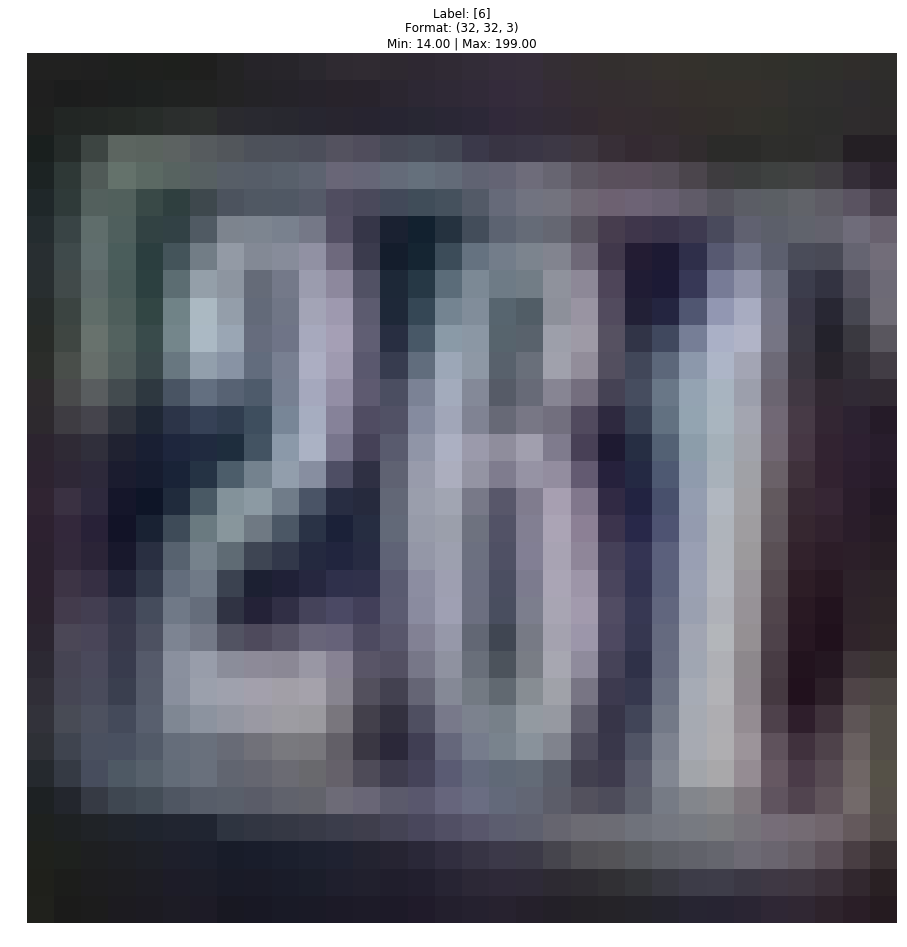

In [61]:
display_sample_images(features, labels, 1, test_data=sample_image_idx)

In [62]:
with tf.Session() as sess:
    resized_image = resize_images(sample_image[:,:,:,np.newaxis])
    feed_dict = {images: resized_image}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code, keep_prob: 1.0}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

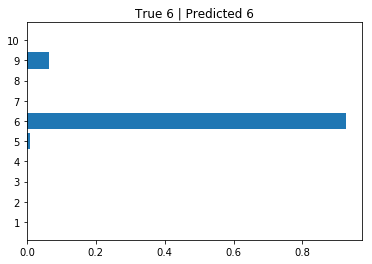

In [63]:
plt.barh(np.arange(10), prediction)
plt.title('True {} | Predicted {}'.format(sample_label[0], np.argmax(prediction) + 1))
plt.yticks(np.arange(10), np.unique(labels))
plt.show()